# NLP Fashion E-Commerce Review Analysis 

###  Part 1: Importing Libraries & Utilities

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import en_core_web_sm
import spacy
import numpy as np
import seaborn as sn
import en_core_web_sm
nlp = en_core_web_sm.load()
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import collections
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.metrics import confusion_matrix



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/malavikamenon/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Part 2: Data Analysis

In [2]:
# Using an index column within the data frama as index
# Code from https://stackoverflow.com/questions/38542419/could-pandas-use-column-as-index

data = pd.read_csv("Womens Clothing E-Commerce Reviews.csv",index_col='Unnamed: 0')
data.head(3)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses


Just by looking at the top 3 lines, we can see that there are clearly missing/NaN values in the dataset which would need to be removed for modelling purposes.

In [3]:
# Initial analysis of data set

print (data.shape)
print (data.columns)

(23486, 10)
Index(['Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')


In [4]:
# To check if there are any columns with missing data to consider
# Code from https://stackoverflow.com/questions/15943769/how-do-i-get-the-row-count-of-a-pandas-dataframe

len(data.index) - data.count()

Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

In [5]:
df = data.copy()

In [6]:
# To eliminate rows that have missing review text since my model will be analysing the text from this column 
# Code from https://stackoverflow.com/questions/18172851/deleting-dataframe-row-in-pandas-based-on-column-value

df_clean = df[~df['Review Text'].isnull()]

In [7]:
# To eliminate duplicate reviews
# Code from https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html

df_clean = df_clean.drop_duplicates(subset=['Review Text', 'Clothing ID', 'Rating'])

In [8]:
print (df_clean.shape)

(22639, 10)


In [9]:
# Total number of fashion products reviewed
# Code from https://stackoverflow.com/questions/45759966/counting-unique-values-in-a-column-in-pandas-dataframe-like-in-qlik/45760042

df_clean['Clothing ID'].nunique()

1179

Text(0.5,0,'Age')

Text(0,0.5,'Number of Reviewers')

Text(0.5,1,'Number of Reviews Based on Age')

(array([1600., 4229., 6280., 4362., 3133., 2171.,  673.,  111.,   68.,
          12.]),
 array([18. , 26.1, 34.2, 42.3, 50.4, 58.5, 66.6, 74.7, 82.8, 90.9, 99. ]),
 <a list of 10 Patch objects>)

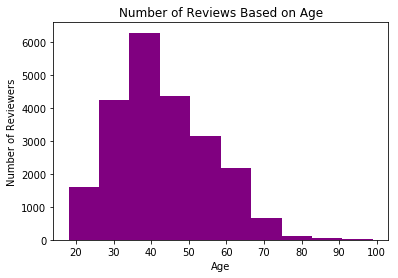

In [11]:
# To see the relationship between the age of the reviewers and the number of reviews provided
# Code from https://datatofish.com/plot-histogram-python/

plt.xlabel('Age')
plt.ylabel('Number of Reviewers')
plt.title ('Number of Reviews Based on Age')
plt.hist(df_clean['Age'],color = "purple")

Ages of reviewers ranged from 18-99 years whereby a sizable proportion of the reviewers were from within the 35-45 age bracket.

Text(0.5,0,'Rating Value')

Text(0,0.5,'Number of Ratings')

Text(0.5,1,'Data on Ratings')

(array([  821.,     0.,  1548.,     0.,     0.,  2823.,     0.,  4908.,
            0., 12539.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

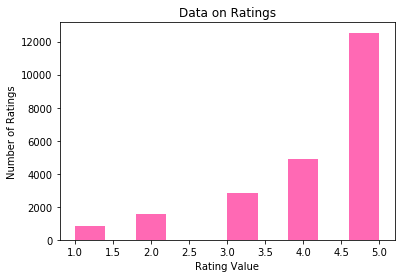

In [12]:
# To understand the relationship between rating value and number of ratings
# Code from https://datatofish.com/plot-histogram-python/

plt.xlabel('Rating Value')
plt.ylabel('Number of Ratings')
plt.title ('Data on Ratings')
plt.hist(df_clean['Rating'],color = "hotpink")

The distribution of ratings across rating values are uneven whereby majority of the raters gave products from the website 4 or 5 stars, indicating that majority of the shoppers had a pleasant experience shopping with this brand and were satisfied with the products they received.  

### Part 3: The Pre-Trained Model

In [13]:
# Eliminating contractions from 'Review Text'
# Code from https://towardsdatascience.com/clothes-reviews-analysis-with-nlp-part-1-d81bdfa14d97

df_clean['Review Text'] = df_clean['Review Text'].apply(lambda x: x.replace("'s", " is").replace("'ll", " will").replace("'ve", " have").replace("'m", " am").replace("\'", "'"))


In [14]:
# Eliminating stop words and punctuation so only nouns, verbs, adjectives, and adverbs will be remaining
# Code from https://towardsdatascience.com/clothes-reviews-analysis-with-nlp-part-1-d81bdfa14d97
    
def lemmatization(x):
    return " ".join([token.lemma_ if token.lemma_ != "-PRON-" else token.text.lower() for sentence in nlp(x).sents for token in sentence if token.pos_ in {"NOUN", "VERB", "ADJ", "ADV", "X"} and token.is_stop == False])
    

In [15]:
# Creating new column of lemmatized text 
# Code from https://towardsdatascience.com/clothes-reviews-analysis-with-nlp-part-1-d81bdfa14d97

df_clean["Lemmas"] = df_clean["Review Text"].apply(lambda x: lemmatization(x))

In [16]:
# Using sentiment analyser to give polarity scores to lemmatized text 
# Code from https://towardsdatascience.com/clothes-reviews-analysis-with-nlp-part-1-d81bdfa14d97

sid = SentimentIntensityAnalyzer()
df_clean["sentiment"] = df_clean["Lemmas"].apply(lambda x: sid.polarity_scores(x))

In [17]:
# Creating new column of compunded scores based on polarity scores 
# Code from https://towardsdatascience.com/clothes-reviews-analysis-with-nlp-part-1-d81bdfa14d97

df_clean['compound']=df_clean['sentiment'].apply(lambda x: x['compound'])
df_clean.head(3)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Lemmas,sentiment,compound
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,absolutely wonderful silky sexy comfortable,"{'neg': 0.0, 'neu': 0.154, 'pos': 0.846, 'comp...",0.8991
1,1080,34,NaN,Love this dress! it is sooo pretty. i happen...,5,1,4,General,Dresses,Dresses,love dress sooo pretty happen find store glad ...,"{'neg': 0.0, 'neu': 0.431, 'pos': 0.569, 'comp...",0.9700
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,high hope dress want work initially order peti...,"{'neg': 0.043, 'neu': 0.663, 'pos': 0.294, 'co...",0.8979


In [18]:
# Distiguishing positive and negative reviews based on scores
# Code from https://towardsdatascience.com/clothes-reviews-analysis-with-nlp-part-1-d81bdfa14d97

def ispositive(x):
    if x<0:
        return 'negative'
    else:
        return 'positive'
        
df_clean['positive-negative']=df_clean["compound"].apply(lambda x: ispositive(x))
df_clean.head(3)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Lemmas,sentiment,compound,positive-negative
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,absolutely wonderful silky sexy comfortable,"{'neg': 0.0, 'neu': 0.154, 'pos': 0.846, 'comp...",0.8991,positive
1,1080,34,NaN,Love this dress! it is sooo pretty. i happen...,5,1,4,General,Dresses,Dresses,love dress sooo pretty happen find store glad ...,"{'neg': 0.0, 'neu': 0.431, 'pos': 0.569, 'comp...",0.9700,positive
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,high hope dress want work initially order peti...,"{'neg': 0.043, 'neu': 0.663, 'pos': 0.294, 'co...",0.8979,positive


In [19]:
# Performing a confusion matrix to test model's performance
# x refers to df_clean ['Recommended IND']
# y refers to df_clean ['positive-negative']

def confusion(x,y):
    if x==0 and y=='negative':
        return 'true negative'
    elif x==0 and y=='positive':
        return 'false positive'
    elif x==1 and y=='negative':
        return 'false negative'
    else:
        return 'true positive'

In [20]:
# Applying function to 'Recommended IND' and 'positive-negative' and creating a new column to display the results

df_clean['confusion']=df_clean[['Recommended IND','positive-negative']].apply(lambda x: confusion(*x),axis=1)
df_clean.head(3)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Lemmas,sentiment,compound,positive-negative,confusion
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,absolutely wonderful silky sexy comfortable,"{'neg': 0.0, 'neu': 0.154, 'pos': 0.846, 'comp...",0.8991,positive,true positive
1,1080,34,NaN,Love this dress! it is sooo pretty. i happen...,5,1,4,General,Dresses,Dresses,love dress sooo pretty happen find store glad ...,"{'neg': 0.0, 'neu': 0.431, 'pos': 0.569, 'comp...",0.9700,positive,true positive
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,high hope dress want work initially order peti...,"{'neg': 0.043, 'neu': 0.663, 'pos': 0.294, 'co...",0.8979,positive,false positive


In [21]:
# To count number of tp, fp, tn, and fn
# Code from https://stackoverflow.com/questions/22391433/count-the-frequency-that-a-value-occurs-in-a-dataframe-column

df_clean['confusion'].value_counts()

true positive     18283
false positive     3587
true negative       513
false negative      256
Name: confusion, dtype: int64

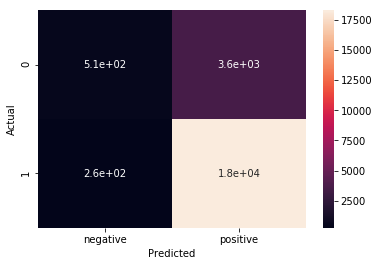

In [22]:
# To create a visual representation of confusion matrix to check for trends
# Code from https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

confusion_matrix = pd.crosstab(df_clean['Recommended IND'], df_clean['positive-negative'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)

plt.show()

As seen in the heat map, 83% of the output was either true positives or true negatives, indicating that the model has been successful to a great extent. To further test the classification accuracy, the values of precision, recall, and the F1 score were calculated. 

In [23]:
# Calculating recall

tp = 18283
fp = 3587
tn = 513
fn = 256
recall= tp / (tp + fn)
recall

0.9861912724526674

In [24]:
# Calculating accuracy

accuracy = (tp + tn)/(tp + tn + fp + fn)
accuracy

0.8302486858960202

In [25]:
# Calculating precision

precision= tp / (tp + fp)
precision

0.8359853680841335

In [26]:
# Calculating F1 score

F1=2*((precision*recall)/(precision+recall))
F1

0.9048974238412235

###  Part 4: The New Model 
#### 4.1: Pre-Processing Data

In [27]:
df_model = data.copy()

In [28]:
from nltk.corpus import stopwords
import string
nltk.download('stopwords')
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/malavikamenon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
# To eliminate rows that have missing review text since my model will be analysing the text from this column 
# Code from https://stackoverflow.com/questions/18172851/deleting-dataframe-row-in-pandas-based-on-column-value

df_model = df_model[~df_model['Review Text'].isnull()]

In [30]:
# To eliminate duplicate reviews
# Code from https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html

df_model = df_model.drop_duplicates(subset=['Review Text', 'Clothing ID', 'Rating'])

In [31]:
# Turning a doc into clean tokens
# Splitting into tokens by white space
# Removing punctuation from each token
# Removing remaining tokens that are not alphabetic
# Filtering out stop words
# Filtering out short tokens
# Code from https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/

def clean_doc(doc):
    
    tokens = doc.split()
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

In [32]:
# Creating new column for tokenised 'Review Text'

df_model["Tokens"] = df_model["Review Text"].apply(lambda x: clean_doc(x))

In [33]:
# Developing a vocabulary of all tokens in the training dataset so that words can be mapped to unique integers
# Code from https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_model['Tokens'])

In [34]:
# Encoding tokens and creating a new column with encoded tokens 
# Code from https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/

df_model['encoded'] = tokenizer.texts_to_sequences(df_model['Tokens'])

In [35]:
# To make all encoded data to be of the same length for effective computation
# Code from https://stackoverflow.com/questions/42002717/how-should-we-pad-text-sequence-in-keras-using-pad-sequences

max_length = max([len(s) for s in df_model['Tokens']])
df_model['encoded'] = pad_sequences(df_model['encoded'], maxlen=max_length, padding='post').tolist()
df_model.head(3)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Tokens,encoded
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,"[Absolutely, wonderful, silky, sexy, comfortable]","[172, 415, 767, 535, 25, 0, 0, 0, 0, 0, 0, 0, ..."
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,"[Love, dress, sooo, pretty, happened, find, st...","[2, 1, 1514, 48, 1145, 146, 57, 9, 222, 731, 3..."
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,"[high, hopes, dress, really, wanted, work, ini...","[127, 931, 1, 16, 121, 52, 986, 17, 44, 13, 16..."


In [36]:
# Defining vocabulary size 
# Code from https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/

vocab_size = len(tokenizer.word_index) + 1

In [37]:
# Splitting data set into training and testing sets 
# Code from https://medium.com/@rinu.gour123/train-and-test-set-in-python-machine-learning-how-to-split-58029a0d657b

train, test = train_test_split(df_model, test_size=0.2)
train.shape
test.shape

(18111, 12)

(4528, 12)

#### 4.2: Defining the Model

In [38]:
# Defining the model
# Code from https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/

model = keras.Sequential()
model.add(layers.Embedding(vocab_size, 100, input_length=max_length))
model.add(layers.Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 59, 100)           1816100   
_________________________________________________________________
conv1d (Conv1D)              (None, 52, 32)            25632     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 26, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 832)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                8330      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 1,850,073
Trainable params: 1,850,073
Non-trainable params: 0
______________________________________________

#### 4.3: Training the Model

In [39]:
x_train = np.array([i for i in train['encoded'].values]

In [40]:
# Fitting the network on the training data
# Keeping track of accuracy/recall/precision in addition to loss during training
# Code from https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall(), keras.metrics.Precision()])
model.fit(x_train, train['Recommended IND'], epochs=10, verbose=2)

Epoch 1/10
566/566 - 20s - loss: 0.3204 - binary_accuracy: 0.8635 - recall: 0.9612 - precision: 0.8823
Epoch 2/10
566/566 - 18s - loss: 0.1889 - binary_accuracy: 0.9230 - recall: 0.9556 - precision: 0.9504
Epoch 3/10
566/566 - 18s - loss: 0.1014 - binary_accuracy: 0.9638 - recall: 0.9768 - precision: 0.9789
Epoch 4/10
566/566 - 17s - loss: 0.0389 - binary_accuracy: 0.9879 - recall: 0.9908 - precision: 0.9944
Epoch 5/10
566/566 - 18s - loss: 0.0135 - binary_accuracy: 0.9968 - recall: 0.9971 - precision: 0.9990
Epoch 6/10
566/566 - 21s - loss: 0.0055 - binary_accuracy: 0.9987 - recall: 0.9990 - precision: 0.9995
Epoch 7/10
566/566 - 18s - loss: 0.0018 - binary_accuracy: 0.9998 - recall: 0.9997 - precision: 1.0000
Epoch 8/10
566/566 - 16s - loss: 6.7998e-04 - binary_accuracy: 0.9999 - recall: 0.9999 - precision: 1.0000
Epoch 9/10
566/566 - 19s - loss: 1.4820e-04 - binary_accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 10/10
566/566 - 18s - loss: 7.8935e-05 - binary_accuracy: 1

#### 4.4: Testing the Model

In [41]:
x_test = np.array([i for i in test['encoded'].values])

In [99]:
# Running model on test data set to get predictions
# Code from https://stackoverflow.com/questions/49975524/get-model-predict-values-in-python/49975792

predictions = model.predict(
      x=x_test
    , batch_size=10
    , verbose=0
)
predictions

array([[1.        ],
       [1.        ],
       [0.25786805],
       ...,
       [1.        ],
       [1.        ],
       [0.78123844]], dtype=float32)

In [100]:
# Creating new column of predictions 

test['predictions']=predictions


/Users/malavikamenon/.pyenv/versions/3.7.0/envs/ds-mala/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#### 4.5: Evaluating the Model

In [101]:
# Creating a function to change predictions from float to integers based on value

def predictions(x):
    if x>0.5: 
        return '1'
    else:
        return '0'

In [103]:
# Creating new column of integer predictions where '1' is positive and '0' is negative

test['final prediction']=test[['predictions']].apply(lambda x: predictions(*x),axis=1)


/Users/malavikamenon/.pyenv/versions/3.7.0/envs/ds-mala/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [106]:
# To count number of tp, fp, tn, and fn
# Code from https://stackoverflow.com/questions/2148543/how-to-write-a-confusion-matrix-in-python

confusion_matrix = pd.crosstab(test['Recommended IND'], test['final prediction'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted    0     1
Actual              
0          470   326
1          244  3488


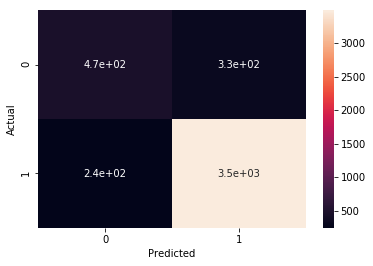

In [107]:
# To create a visual representation of confusion matrix to check for trends
# Code from https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

confusion_matrix = pd.crosstab(test['Recommended IND'], test['final prediction'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)

plt.show()

As seen in the heat map, 87.4% of the output was either true positives or true negatives, indicating that the model has been successful to a great extent. To further test the classification accuracy, the values of precision, recall, and the F1 score were calculated. 

In [112]:
# Calculating recall

TP=3488
TN=470
FP=326
FN=244 
Recall= TP / (TP + FN)
Recall

0.9346195069667739

In [113]:
# Calculating accuracy

Accuracy = (TP + TN)/(TP + TN + FP + FN)
Accuracy

0.8741166077738516

In [114]:
# Calculating precision

Precision= TP / (TP + FP)
Precision

0.9145254326166754

In [115]:
# Calculating F1 Score

F1Score=2*((Precision*Recall)/(Precision+Recall))
F1Score

0.9244632918102306

### Part 5: Evaluation 

The new model outperformed the pre-trained model in terms of accuracy by 5.3%, and precision by 9.3%. However, the pre-trained model had a better recall rate by 5.2%. Nonetheless, the new model has a F1 score that is 2.2% higher than that of the pre-trained model. Given the fact that the new model outperformed the pre-trained model in terms of accuracy, precision, and has a higher weighted average of precision and recall, it can be considered to be the more successful model. 